In [1]:
MAX_TIME = 30
INIT_SIZE = 10
DEVICE = "cpu" # "cuda:0"

In [2]:
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
experiment_name

'14-torch_bartz09_30min_10init_2023-05-14_09-01-29'

# Chapter 14: Sequential Parameter Optimization Compared to Ray Tune
## Hyperparameter Tuning: pytorch wth cifar10 Data

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).


In [3]:
pip list | grep  "spot[RiverPython]"

spotPython               0.0.70
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


In [5]:
from tabulate import tabulate
import copy
import warnings
import numbers
import json
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt

from functools import partial

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    convert_keys,
    get_bound_values,
    get_default_hyperparameters_for_core_model,
    get_default_values,
    get_dict_with_levels_and_types,
    get_values_from_dict,
    get_var_name,
    get_var_type,
    iterate_dict_values,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    replace_levels_with_positions,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
    transform_hyper_parameter_values,
    get_dict_with_levels_and_types,
    convert_keys,
    iterate_dict_values,
)

from spotPython.torch.traintest import evaluate_cv, evaluate_hold_out
from spotPython.utils.convert import class_for_name
from spotPython.utils.eda import (
    get_stars,
    gen_design_table)
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.convert import get_Xy_from_df
from spotPython.utils.init import fun_control_init
from spotPython.plot.validation import plot_cv_predictions, plot_roc, plot_confusion_matrix

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch

warnings.filterwarnings("ignore")

from spotPython.torch.netcifar10 import Net_CIFAR10

In [6]:
print(torch.__version__)
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("MPS device: ", mps_device)

2.0.1
MPS device:  mps


## 0. Initialization of the Empty `fun_control` Dictionary

In [7]:
fun_control = fun_control_init()

## 1. Load Cifar10 Data 

The data loading is implemented as in the Section "Data loaders" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [8]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [9]:
train, test = load_data()
train.data.shape, test.data.shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [10]:
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": None, # dataset,
               "train": train,
               "test": test,
               "n_samples": n_samples,
               "target_column": None})

## 2. Specification of the Preprocessing Model

Because the Ray Tune hyperparameter tuning does not use a preprocessing model, the preprocessing model is set to `None` here.

In [11]:
# categorical_columns = []
# one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# prep_model = ColumnTransformer(
#         transformers=[
#             ("categorical", one_hot_encoder, categorical_columns),
#         ],
#         remainder=StandardScaler(),
#     )
prep_model = None
fun_control.update({"prep_model": prep_model})

## 3. Select `algorithm` and `core_model_hyper_dict`

The same model as implemented as in the Section "Configurable neural network" in the PyTorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) is used here. `spotPython` implements a class which is similar to the class described in the PyTorch tutorial. The class is called `Net_CIFAR10`   and is implemented in the file `netcifar10.py`. The class is imported here.

Note: In addition to the class Net from the PyTorch tutorial, the class Net_CIFAR10 has additional attributes, namely:

* learning rate (`lr`),
* batchsize (`batch_size`),
* epochs (`epochs`), and
* k_folds (`k_folds`).

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.

In [12]:
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters. The `JSON` file for the `core_model` is called `torch_hyper_dict.json`. The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
                "type": "int",
                "default": 3,
                "transform": "transform_power_2_int",
                "lower": 1,
                "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
    }
}
```

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.


### Categorical Hyperparameters

In contrast to Ray Tune, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `Ray Tune` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## 4. Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a clever rule for de-activating hyperparameters. If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.

### Modify hyperparameter of type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the PyTorch tutorial, it is de-activated here by setting the lower and upper bound to the same value.

In [13]:
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[1, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 2])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 5},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0},
 'patience': {'type': 'int',
  'default': 5,
  'transform': 'None',
  'lower': 2,
  'upper': 2}}

### Modify hyperparameter of type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified. For example, the hyperparameter `leaf_model` is de-activated here by choosing only one value `"LinearRegression"`.

In [14]:
# fun_control = modify_hyper_parameter_levels(fun_control, "leaf_model", ["LinearRegression"])

## 5. Selection of the Objective (Loss) Function

There are two metrics:

    1. `metric` is used for the river based evaluation via `eval_oml_iter_progressive`.
    2. `metric_sklearn` is used for the sklearn based evaluation.

**Important**:

* `spotPython` performs minimization by default.
* If accuracy should be maximized, then the objective function has to be multiplied by -1. Therefore, `weights` is set to -1 in this case.

In [15]:
fun = HyperTorch(seed=123, log_level=50).fun_torch
weights = 1.0
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
save_model = True
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "save_model": save_model,
               "path": path,
               })

## 6. Calling the SPOT Function

### Prepare the SPOT Parameters

* Get types and variable names as well as lower and upper bounds for the hyperparameters.

In [17]:
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

In [18]:
print(gen_design_table(fun_control))

| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    5    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |
| patience   | int    |     5     |   2     |    2    | None                  |


### Run the `Spot` Optimizer

* Run SPOT for approx. x mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [19]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[5.e+00, 5.e+00, 1.e-03, 4.e+00, 3.e+00, 2.e+00, 5.e+00]])

In [20]:
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

Epoch: 1
Loss on hold-out set: 1.6233964078903198
Accuracy on hold-out set: 0.38105
Epoch: 2
Loss on hold-out set: 1.4671174495697021
Accuracy on hold-out set: 0.4661
Epoch: 3
Loss on hold-out set: 1.3931800443649291
Accuracy on hold-out set: 0.48835
Epoch: 4
Loss on hold-out set: 1.292147557067871
Accuracy on hold-out set: 0.53945
Epoch: 5
Loss on hold-out set: 1.2439146033763886
Accuracy on hold-out set: 0.5612
Epoch: 6
Loss on hold-out set: 1.229163365507126
Accuracy on hold-out set: 0.56355
Epoch: 7
Loss on hold-out set: 1.2038760988712311
Accuracy on hold-out set: 0.57745
Epoch: 8
Loss on hold-out set: 1.1792098928928376
Accuracy on hold-out set: 0.58755
Epoch: 9
Loss on hold-out set: 1.1812366831302643
Accuracy on hold-out set: 0.5961
Epoch: 10
Loss on hold-out set: 1.2029704758405686
Accuracy on hold-out set: 0.58735
Early stopping at epoch 9
Returned to Spot: Validation loss: 1.2029704758405686
----------------------------------------------
Epoch: 1
Loss on hold-out set: 1.9378

### 4 Results

In [21]:
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

* Show the Progress of the hyperparameter tuning:

In [22]:
spot_tuner.y

array([1.20297048, 1.25395121, 1.24557465, 1.27257742, 1.213883  ,
       1.14901585, 1.66829299, 1.31863862, 1.46547921, 1.38934165,
       1.49830928, 2.23691175, 1.18338012, 1.18497445, 1.30009179,
       1.23024179, 1.14079642, 1.21185805, 1.16077411, 1.19372865])

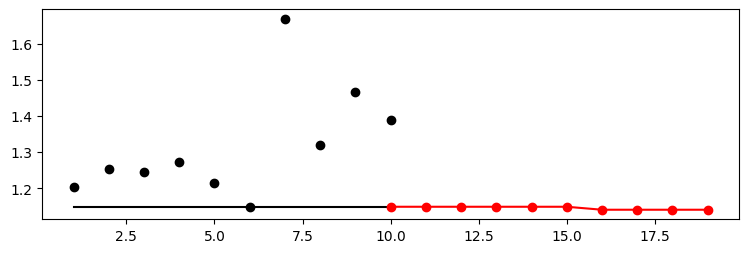

In [23]:
spot_tuner.plot_progress(log_y=False, filename="../Figures.d/" + experiment_name+"_progress.pdf")

* Print the Results

In [24]:
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   |   default |   lower |   upper |                 tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|-----------------------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                   5.0 | transform_power_2_int |         0.00 |         |
| l2         | int    |       5.0 |     2.0 |     9.0 |                   6.0 | transform_power_2_int |        59.72 | **      |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.0061938511645919245 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     5.0 |                   3.0 | transform_power_2_int |         0.00 |         |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                   4.0 | transform_power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                   0.0 | None             

## Show variable importance

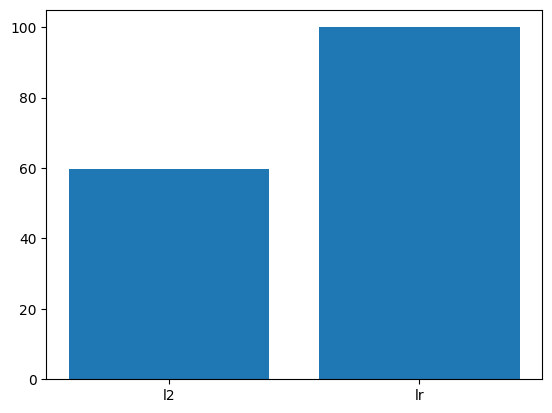

In [25]:
spot_tuner.plot_importance(threshold=0.025, filename="../Figures.d/" + experiment_name+"_importance.pdf")

## Get Default Hyperparameters

In [26]:
values_default = get_default_values(fun_control)
values_default = transform_hyper_parameter_values(fun_control=fun_control, hyper_parameter_values=values_default)
values_default

{'l1': 32,
 'l2': 32,
 'lr': 0.001,
 'batch_size': 16,
 'epochs': 8,
 'k_folds': 2,
 'patience': 5}

In [27]:
model_default = fun_control["core_model"](**values_default)
model_default

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

## Get SPOT Results

In [28]:
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
print(X)

[[5.         6.         0.00619385 3.         4.         0.
  2.        ]]


In [29]:
v_dict = assign_values(X, fun_control["var_name"])
return_conf_list_from_var_dict(var_dict=v_dict, fun_control=fun_control)

[{'l1': 32,
  'l2': 64,
  'lr': 0.0061938511645919245,
  'batch_size': 8,
  'epochs': 16,
  'k_folds': 0,
  'patience': 2}]

In [30]:
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

# Evaluations

Two evaluations are performed: First, the test data is used only: the test data is used for training the model and for evaluating the model. Second, the train and test data are used: the model is trained with the train data and evaluated with the test data.

## Test Set Accuracy

The tuned model architecture (i.e., the model without pre-trained weights) is used for training and testing the model with the test data.

In [31]:
testset = fun_control["test"]
testset.data.shape

(10000, 32, 32, 3)

The default model is considered first.

In [32]:
evaluate_hold_out(model_default, train_dataset = testset, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 2.3050656270980836
Accuracy on hold-out set: 0.09975
Epoch: 2
Loss on hold-out set: 2.2965300445556642
Accuracy on hold-out set: 0.11775
Epoch: 3
Loss on hold-out set: 2.258738248825073
Accuracy on hold-out set: 0.17375
Epoch: 4
Loss on hold-out set: 2.1725740132331848
Accuracy on hold-out set: 0.22125
Epoch: 5
Loss on hold-out set: 2.1180462989807127
Accuracy on hold-out set: 0.244
Epoch: 6
Loss on hold-out set: 2.0713137321472166
Accuracy on hold-out set: 0.26125
Epoch: 7
Loss on hold-out set: 2.0193002371788027
Accuracy on hold-out set: 0.2845
Epoch: 8
Loss on hold-out set: 1.9716885032653808
Accuracy on hold-out set: 0.29625
Returned to Spot: Validation loss: 1.9716885032653808
----------------------------------------------


(1.9716885032653808, nan)

Next, the tuned spot model is evaluated:

In [33]:
evaluate_hold_out(model_spot, train_dataset = testset, shuffle=False, show_batch_interval=1_000)

Epoch: 1
Loss on hold-out set: 1.9347917926311493
Accuracy on hold-out set: 0.295
Epoch: 2
Loss on hold-out set: 1.792825924396515
Accuracy on hold-out set: 0.3525
Epoch: 3
Loss on hold-out set: 1.706874286532402
Accuracy on hold-out set: 0.37875
Epoch: 4
Loss on hold-out set: 1.6501392506361008
Accuracy on hold-out set: 0.398
Epoch: 5
Loss on hold-out set: 1.5971985567808151
Accuracy on hold-out set: 0.42125
Epoch: 6
Loss on hold-out set: 1.5571587350368499
Accuracy on hold-out set: 0.43675
Epoch: 7
Loss on hold-out set: 1.5368325031995773
Accuracy on hold-out set: 0.448
Epoch: 8
Loss on hold-out set: 1.5133848513364792
Accuracy on hold-out set: 0.4585
Epoch: 9
Loss on hold-out set: 1.5058273146152497
Accuracy on hold-out set: 0.4635
Epoch: 10
Loss on hold-out set: 1.4967313861250877
Accuracy on hold-out set: 0.47225
Epoch: 11
Loss on hold-out set: 1.4995892196893692
Accuracy on hold-out set: 0.47525
Epoch: 12
Loss on hold-out set: 1.5011296877264977
Accuracy on hold-out set: 0.48325


(1.5011296877264977, nan)

## Train on Train Data and Test on Test Data (Hold-Out)

The final evaluation is performed with the train and test data. The model (without pre-trained weights) is trained with the train data and evaluated with the test data.

In [34]:
trainset = fun_control["train"]

In [35]:
evaluate_hold_out(net=model_default, train_dataset=trainset, shuffle=False, test_dataset=testset, show_batch_interval=1_000) 

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 1.949
Batch:  2000. Batch Size: 16. Training Loss (running): 0.927
Batch:  3000. Batch Size: 16. Training Loss (running): 0.602
Loss on hold-out set: 1.7496077575683593
Accuracy on hold-out set: 0.3541
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 1.745
Batch:  2000. Batch Size: 16. Training Loss (running): 0.844
Batch:  3000. Batch Size: 16. Training Loss (running): 0.558
Loss on hold-out set: 1.6321999143600463
Accuracy on hold-out set: 0.3948
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 1.640
Batch:  2000. Batch Size: 16. Training Loss (running): 0.803
Batch:  3000. Batch Size: 16. Training Loss (running): 0.536
Loss on hold-out set: 1.5757465740203858
Accuracy on hold-out set: 0.4182
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 1.582
Batch:  2000. Batch Size: 16. Training Loss (running): 0.775
Batch:  3000. Batch Size: 16. Training Loss (running): 0.520
Loss on ho

(1.4194196988105774, nan)

In [36]:
evaluate_hold_out(net=model_spot, train_dataset=trainset, shuffle=False, test_dataset=testset, show_batch_interval=1_000)

Epoch: 1
Batch:  1000. Batch Size: 8. Training Loss (running): 1.435
Batch:  2000. Batch Size: 8. Training Loss (running): 0.708
Batch:  3000. Batch Size: 8. Training Loss (running): 0.455
Batch:  4000. Batch Size: 8. Training Loss (running): 0.330
Batch:  5000. Batch Size: 8. Training Loss (running): 0.272
Batch:  6000. Batch Size: 8. Training Loss (running): 0.221
Loss on hold-out set: 1.263848412847519
Accuracy on hold-out set: 0.5475
Epoch: 2
Batch:  1000. Batch Size: 8. Training Loss (running): 1.257
Batch:  2000. Batch Size: 8. Training Loss (running): 0.639
Batch:  3000. Batch Size: 8. Training Loss (running): 0.414
Batch:  4000. Batch Size: 8. Training Loss (running): 0.303
Batch:  5000. Batch Size: 8. Training Loss (running): 0.250
Batch:  6000. Batch Size: 8. Training Loss (running): 0.204
Loss on hold-out set: 1.2044066270589828
Accuracy on hold-out set: 0.571
Epoch: 3
Batch:  1000. Batch Size: 8. Training Loss (running): 1.169
Batch:  2000. Batch Size: 8. Training Loss (run

(1.1619986588835716, nan)

## Additional Evaluations

The method `train_save` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model model_state_dict is saved.

 This evaluation is similar to the final Evaluation as in the Pytorch tutorial [Hyperparameter Tuning  with Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html).

In [37]:
model_spot

Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [38]:
from spotPython.torch.traintest import train_save
train_save(net=model_spot, train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt", save_model=True)

Epoch: 1
Batch:  1000. Batch Size: 8. Training Loss (running): 0.968
Batch:  2000. Batch Size: 8. Training Loss (running): 0.482
Batch:  3000. Batch Size: 8. Training Loss (running): 0.316
Loss on hold-out set: 0.9548656731963158
Accuracy on hold-out set: 0.6684
Epoch: 2
Batch:  1000. Batch Size: 8. Training Loss (running): 0.897
Batch:  2000. Batch Size: 8. Training Loss (running): 0.468
Batch:  3000. Batch Size: 8. Training Loss (running): 0.318
Loss on hold-out set: 0.9443260886669159
Accuracy on hold-out set: 0.67345
Epoch: 3
Batch:  1000. Batch Size: 8. Training Loss (running): 0.883
Batch:  2000. Batch Size: 8. Training Loss (running): 0.460
Batch:  3000. Batch Size: 8. Training Loss (running): 0.306
Loss on hold-out set: 0.9774431721895933
Accuracy on hold-out set: 0.6632
Epoch: 4
Batch:  1000. Batch Size: 8. Training Loss (running): 0.869
Batch:  2000. Batch Size: 8. Training Loss (running): 0.440
Batch:  3000. Batch Size: 8. Training Loss (running): 0.297
Loss on hold-out set:

(0.9829420218974352, nan)

In [39]:
from spotPython.torch.traintest import  test_saved
test_saved(net=model_spot, test_dataset=test, shuffle=False, device = "cpu", show_batch_interval=1_000, path="model_spot_trained.pt")

Loss on hold-out set: 1.0764226425528527
Accuracy on hold-out set: 0.6414
Returned to Spot: Validation loss: 1.0764226425528527
----------------------------------------------


(1.0764226425528527, nan)

## Detailed Hyperparameter Plots

* For productive use, you might want to select:
  * `min_z=min(spot_tuner.y)` and
  * `max_z = max(spot_tuner.y)`
* These settings are not so colorful as visualizations that use `None` for the ranges, but give better insights.

l2:  59.72029949358751
lr:  100.0


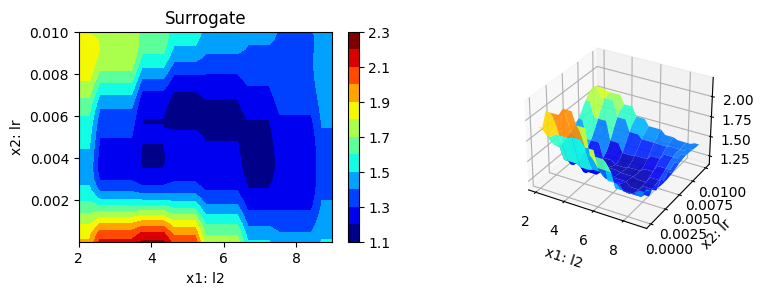

In [40]:
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "../Figures.d/" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

## Parallel Coordinates Plot

In [41]:
spot_tuner.parallel_plot()

## Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [42]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)